In [2]:
import sys
sys.executable

'/home/ec2-user/anaconda3/envs/python3/bin/python'

In [5]:
sys.path

['',
 '/home/ec2-user/anaconda3/envs/python3/lib/python36.zip',
 '/home/ec2-user/anaconda3/envs/python3/lib/python3.6',
 '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/lib-dynload',
 '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages',
 '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/extensions',
 '/home/ec2-user/.ipython']

In [1]:
conda env list

# conda environments:
#
base                     /home/ec2-user/anaconda3
JupyterSystemEnv         /home/ec2-user/anaconda3/envs/JupyterSystemEnv
R                        /home/ec2-user/anaconda3/envs/R
amazonei_mxnet_p27       /home/ec2-user/anaconda3/envs/amazonei_mxnet_p27
amazonei_mxnet_p36       /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36
amazonei_pytorch_latest_p36     /home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p36
amazonei_tensorflow2_p27     /home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p27
amazonei_tensorflow2_p36     /home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36
amazonei_tensorflow_p27     /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p27
amazonei_tensorflow_p36     /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36
chainer_p27              /home/ec2-user/anaconda3/envs/chainer_p27
chainer_p36              /home/ec2-user/anaconda3/envs/chainer_p36
mxnet_latest_p37         /home/ec2-user/anaconda3/envs/mxnet_latest_p37
mxnet_p27            

In [3]:
import io
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from datetime import date
import datetime

import gc

# import Sklearn packages
import sklearn.model_selection
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

# import graphviz



In [9]:
# to allow multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [10]:
# fix the auto tab completion in sagemaker
%config Completer.use_jedi = False

In [11]:
# set up sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# set up s3 bucket 
chime_exercise_bucket = sagemaker_session.default_bucket()
prefix = 'chime-takehome-exercise-data'

## Step 1: read-in data from s3 location

In [4]:
'''
read-in credit card fraud data 
'''
df = pd.read_csv('s3://sagemaker-us-east-1-800200736538/chime-takehome-exercise-data/creditcard.csv')

## Step 2: data pre-processing, sanity/missing check, basic EDA

In [41]:
'''
data preview
'''
df.shape
df.info()
df.head(10)

'\ndata preview\n'

(284807, 31)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


### *Step 2.1: Understand the data imbalance and calculate the fraud percentage*

In [103]:
'''
understand the data imbalance 
'''
# Calculate the fraction of data points that are fraudulent
def fraud_percentage(input_df):
    ''''Class' label of fraudulant: 1; healthy: zero
       :return: A fractional percentage of fraudulent data points/all points
    '''
    # counts for all classes
    counts = input_df['Class'].value_counts()
    
    # get fraudulent and valid cnts
    fraud_cnts = counts[1]
    valid_cnts = counts[0]
    
    # calculate percentage of fraudulent data
    fraud_percentage = fraud_cnts/(fraud_cnts+valid_cnts)
    
    return fraud_percentage

In [106]:
# Print the fraud percentage
fraud_percentage = fraud_percentage(df)

print('Fraudulent percentage = ', fraud_percentage)
print('Total # of fraudulent pts: ', fraud_percentage*df.shape[0])
print('Out of (total) pts: ', df.shape[0])

Fraudulent percentage =  0.001727485630620034
Total # of fraudulent pts:  492.0
Out of (total) pts:  284807


### *Step 2.2: Check the missing data*

In [63]:
'''
check data missing (null/infinity)
'''
def null_inf_check(input_df):
    # check any missing or infinite values
    print('There are following null fields: {}'.format(input_df.isnull().any())) 
    # check missing row count by columns
    print('There are following number of missing values in each variable: {}'.format(input_df.isnull().sum()))
    # check missing percentage
    print('Here is the missing percentage of each input variable: {}'.format(input_df.isnull().sum()/len(input_df)))

# visualize the missing data
def plot_missing(input_df):
    sns.heatmap(input_df.isnull(),
                yticklabels=False,
                cbar=False,
                cmap='viridis')

'\ncheck data missing (null/infinity)\n'

'\nprint/plot missing data summary\n'

There are following null fields: Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool
There are following number of missing values in each variable: Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Here is the

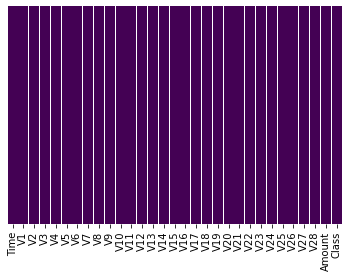

In [64]:
'''
print/plot missing data summary
'''
null_inf_check(df)
plot_missing(df)


### *Step 2.3: check individual predictor's distribution*

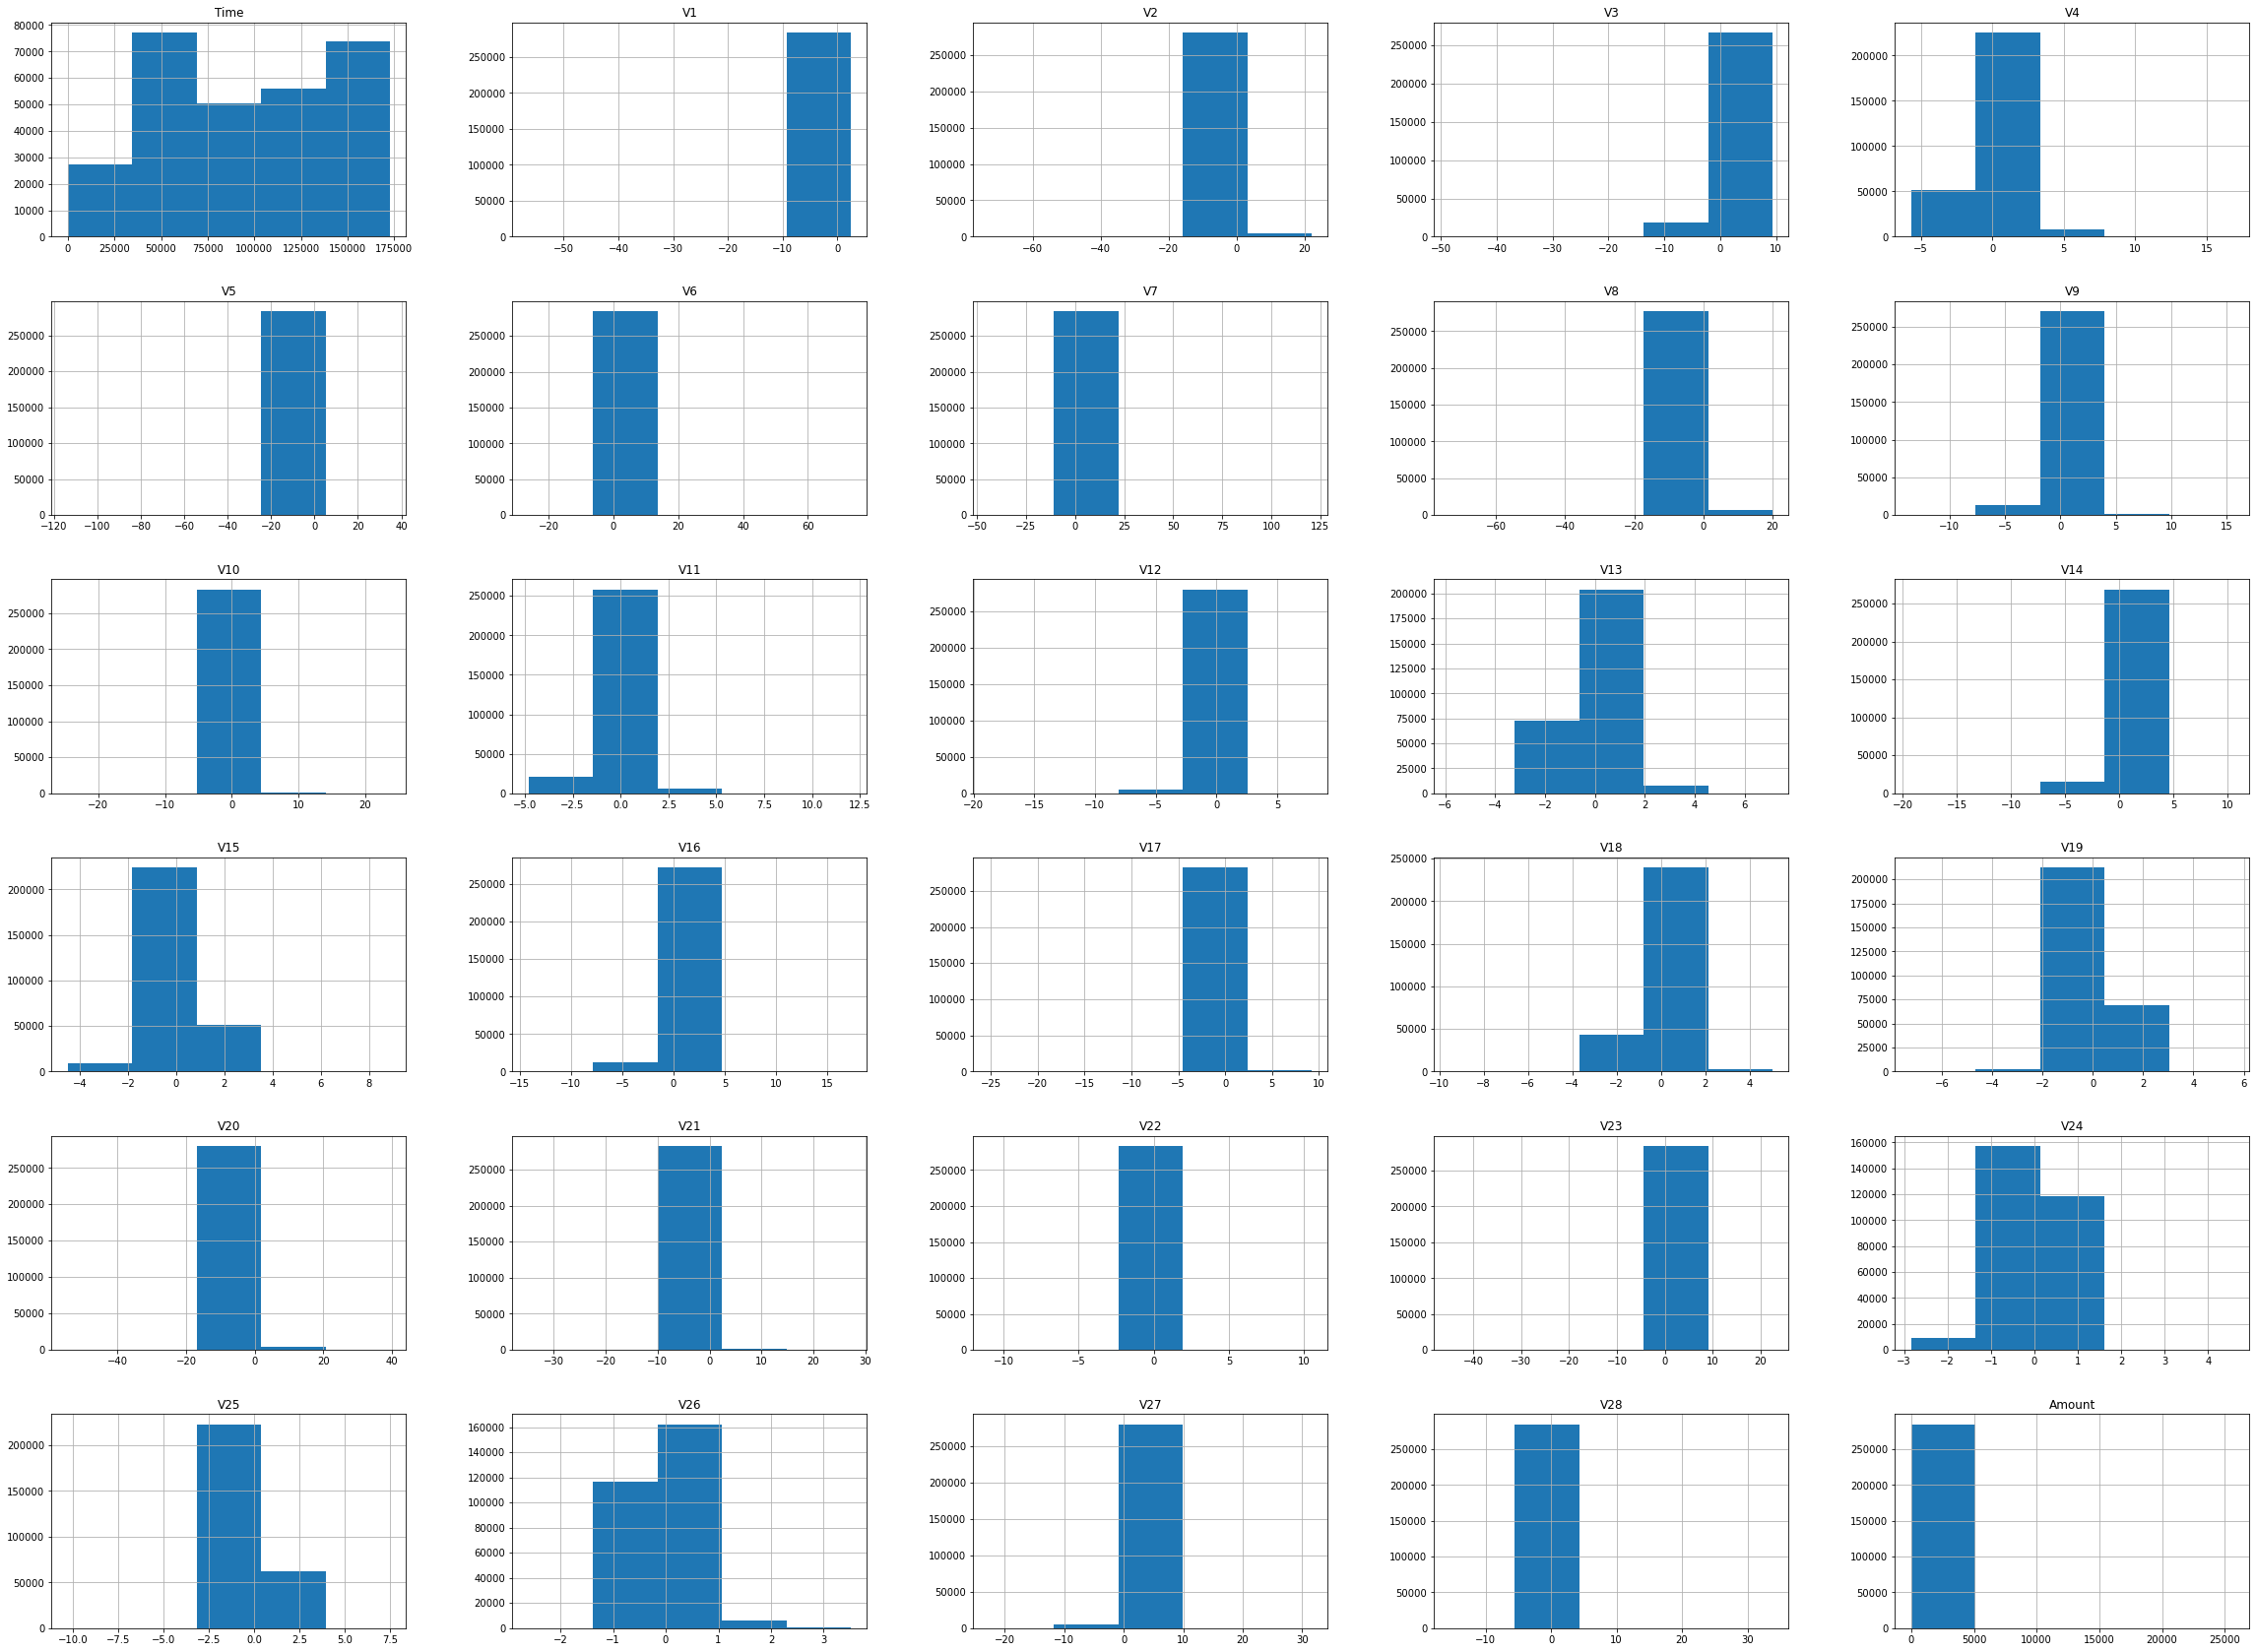

In [210]:
'''
check variable distribution 
'''
var_list = df.columns[:-1]
df[var_list].hist(bins=5, figsize=(40,30))
plt.show()

## Step 3: Train/Test data split before choosing the decision tree methods

In [116]:
predictor = df.columns[:-1]

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df[predictor], df['Class'], test_size=0.33,random_state=41)

## Step 4: Define the grid search function to identify the optimal parameters for a decision tree model (tree decision criteria, tree-depth, and weight)

In [173]:
'''
Grid search for optimal tree-depth in the baseline tree
'''
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

def grid_search_best_tree (X_train_data, y_train_data, tree_depth_range, cv_fold, class_weight):
    tree_criterion = ['gini','entropy']
    max_depth_val = list(range(3,10))
    class_weight = class_weight
    model = DecisionTreeClassifier(class_weight = class_weight)
    # define grid search & evaluation procedure (using 5-fold cross validation)
    parameters = dict(criterion=tree_criterion,
                      max_depth=tree_depth_range,
                      class_weight = class_weight)
    clf_grid = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=-1, cv=cv_fold)
    # cross validation train models 
    return clf_grid.fit(X_train_data, y_train_data)



## Step 5: Build the baseline decision tree model (without additional imbalance treatment such as upsampling and applying weights)

### *Step 5.1: Apply the grid search function to identify optimal parameters for a basline decision tree model* 

In [175]:
%%time
'''
Grid search to get the optimal parameters for the baseline tree model 
'''
# limit tree depth range to between 3 and 8
tree_depth_range = list(range(3,8))
### *Step 4.1: Build grid search function to identify optimal parameters for a decision tree model (tree decision criteria, tree-depth, weight)*
# conduct 3-fold cross-validation 
cv_fold = 3

# apply equal weight to decision tree
class_weight = ['balanced']
# fit the baseline tree model 
baseline_grid_search_tree = grid_search_best_tree(X_train, y_train, tree_depth_range, cv_fold, class_weight)

# the optimal parameters
baseline_grid_search_tree.best_estimator_.get_params()

CPU times: user 6.53 s, sys: 76.1 ms, total: 6.61 s
Wall time: 1min 19s


{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

### *Step 5.2: Apply the baseline tree model to the training data* 

In [176]:
'''
Build the baseline tree model 
'''
best_estimator = baseline_grid_search_tree.best_estimator_

# clf_baseline = DecisionTreeClassifier(best_estimator)
baseline_tree_model = best_estimator.fit(X_train, y_train)


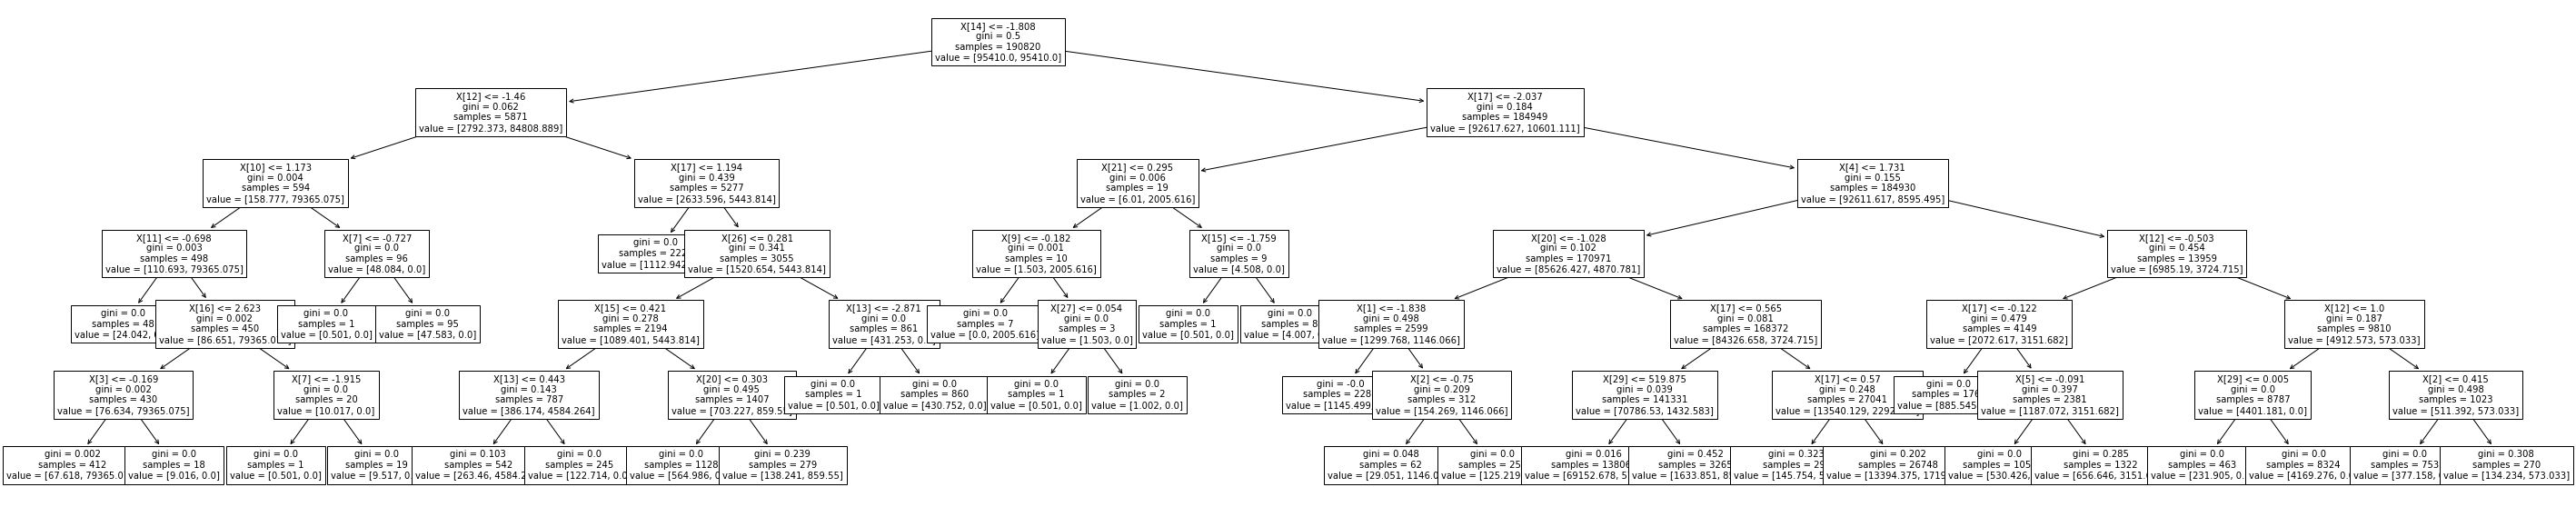

In [177]:
'''
Plot the baseline tree model
'''
plt.figure(figsize=(50,10))
tree.plot_tree(best_estimator, fontsize=10)
plt.show()

### *Step 5.3: Calculate the baseline model metrics: accuracy, precision, recall, F1-Score* 

The baseline tree model accuracy is :0.984763850319725
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     93828
           1       0.08      0.80      0.15       159

    accuracy                           0.98     93987
   macro avg       0.54      0.89      0.57     93987
weighted avg       1.00      0.98      0.99     93987

The baseline tree model confusion matrix: <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f8893efd9b0>


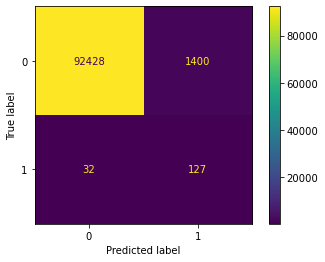

In [178]:
'''
Evaluate baseline model performance
'''
# Fit test data
y_pred = best_estimator.predict(X_test)


# Accuracy
accuracy = accuracy_score(y_test, y_pred)

print('The baseline tree model accuracy is :{}'.format(accuracy))

# classification report (precision, recall, f1-score)
print(classification_report(y_test, y_pred))

# Confusion Matrix
print('The baseline tree model confusion matrix: {}'.format(plot_confusion_matrix(best_estimator, X_test, y_test, values_format = 'd')))



### *Step 5.4: Calculate the average precision score and plot APPRC* 

The baseline precision is: 0.001727485630620034
The averge precision is: 0.4835726068362793


Text(0.5, 1.0, 'The baseline tree model Precision-Recall curve: AP=0.48')

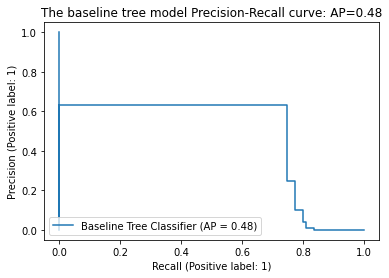

In [207]:
# precision, recall, _ = precision_recall_curve(y_test, y_pred)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

baseline_tree_y_score = best_estimator.fit(X_train, y_train).predict_proba(X_test)

tree_ap_score = average_precision_score(y_test, baseline_tree_y_score[:,1])

print('The baseline precision is: {}'.format(fraud_percentage))
print('The averge precision is: {}'.format(tree_ap_score))
disp = plot_precision_recall_curve(best_estimator, X_test, y_test, name = 'Baseline Tree Classifier')
disp.ax_.set_title('The baseline tree model Precision-Recall curve: '
                   'AP={0:0.2f}'.format(tree_ap_score))

### *Step 5.5: Summarize the feature importance of the baseline decision tree model* 

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.01080
Feature: 2, Score: 0.00614
Feature: 3, Score: 0.00021
Feature: 4, Score: 0.01889
Feature: 5, Score: 0.00728
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00003
Feature: 10, Score: 0.00109
Feature: 11, Score: 0.00055
Feature: 12, Score: 0.03831
Feature: 13, Score: 0.00244
Feature: 14, Score: 0.80994
Feature: 15, Score: 0.00376
Feature: 16, Score: 0.00023
Feature: 17, Score: 0.07163
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.01598
Feature: 21, Score: 0.00010
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00641
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00622


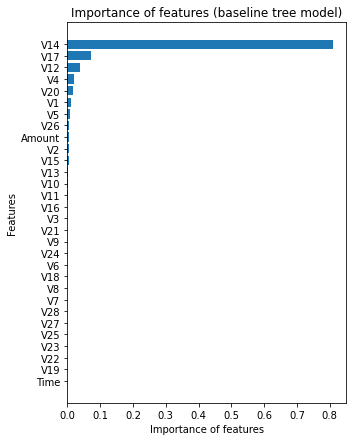

In [198]:
'''
Summarize the feature importance
'''
# get importance
imp = best_estimator.feature_importances_


# summarize feature importance
for i,v in enumerate(imp):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance    
names = X_train.columns
imp, names = zip(*sorted(zip(imp, names)))
plt.figure(figsize=(5,7))
plt.barh(range(len(names)),imp,align='center')
plt.yticks(range(len(names)), names)
plt.xlabel('Importance of features')
plt.ylabel('Features')
plt.title('Importance of features (baseline tree model)')
plt.show()

## Step 6: Upsample the "bad" class as the fraud data is extremely imbalanced

### *Step 6.1 Upsample the training data by increase the presense of "fraud" label in the training data (upsample fraud transactions to make the fraud label accounting for 25% of training data)*

In [134]:
from sklearn.utils import resample

# Concatenate X_train, y_train for oversampling 
X = pd.concat([X_train, y_train], axis=1)

# check class counts
X.Class.value_counts()

0    190487
1       333
Name: Class, dtype: int64

In [143]:
# separate minority and majority classes
non_fraud_train = X[X.Class==0]
fraud_train = X[X.Class==1]

# oversample minority
fraud_train_upsample = resample(fraud_train,
                          replace=True, # sample with replacement
                          n_samples=int(0.25*len(non_fraud_train)),# 
                          random_state=41) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([non_fraud_train, fraud_train_upsample])

# check new class counts
upsampled.Class.value_counts()

# new training data based on upsampled results
predictor = df.columns[:-1]
upsampled_X_train = upsampled[predictor]
upsampled_y_train = upsampled['Class']


### *Step 6.2: Apply the grid search function to identify optimal parameters for the upsampled decision tree model* 

In [144]:
%%time
'''
Grid search to get the optimal parameters for the baseline tree model 
'''
# limit tree depth range to between 3 and 8
tree_depth_range = list(range(3,8))

# conduct 3-fold cross-validation 
cv_fold = 3

# apply equal weight to decision tree
class_weight = 'balanced'

# fit the baseline tree model 
upsample_grid_search_tree = grid_search_best_tree(upsampled_X_train, upsampled_y_train, tree_depth_range, cv_fold, class_weight)

upsample_grid_search_tree.best_estimator_.get_params()

CPU times: user 7.34 s, sys: 56.3 ms, total: 7.39 s
Wall time: 1min 18s


{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

### *Step 6.3: Apply the baseline tree model to the upsampled training data* 

In [145]:
'''
Build the upsampled tree model 
'''
upsample_best_estimator = upsample_grid_search_tree.best_estimator_

# clf_baseline = DecisionTreeClassifier(best_estimator)
upsample_tree_model = upsample_best_estimator.fit(upsampled_X_train, upsampled_y_train)


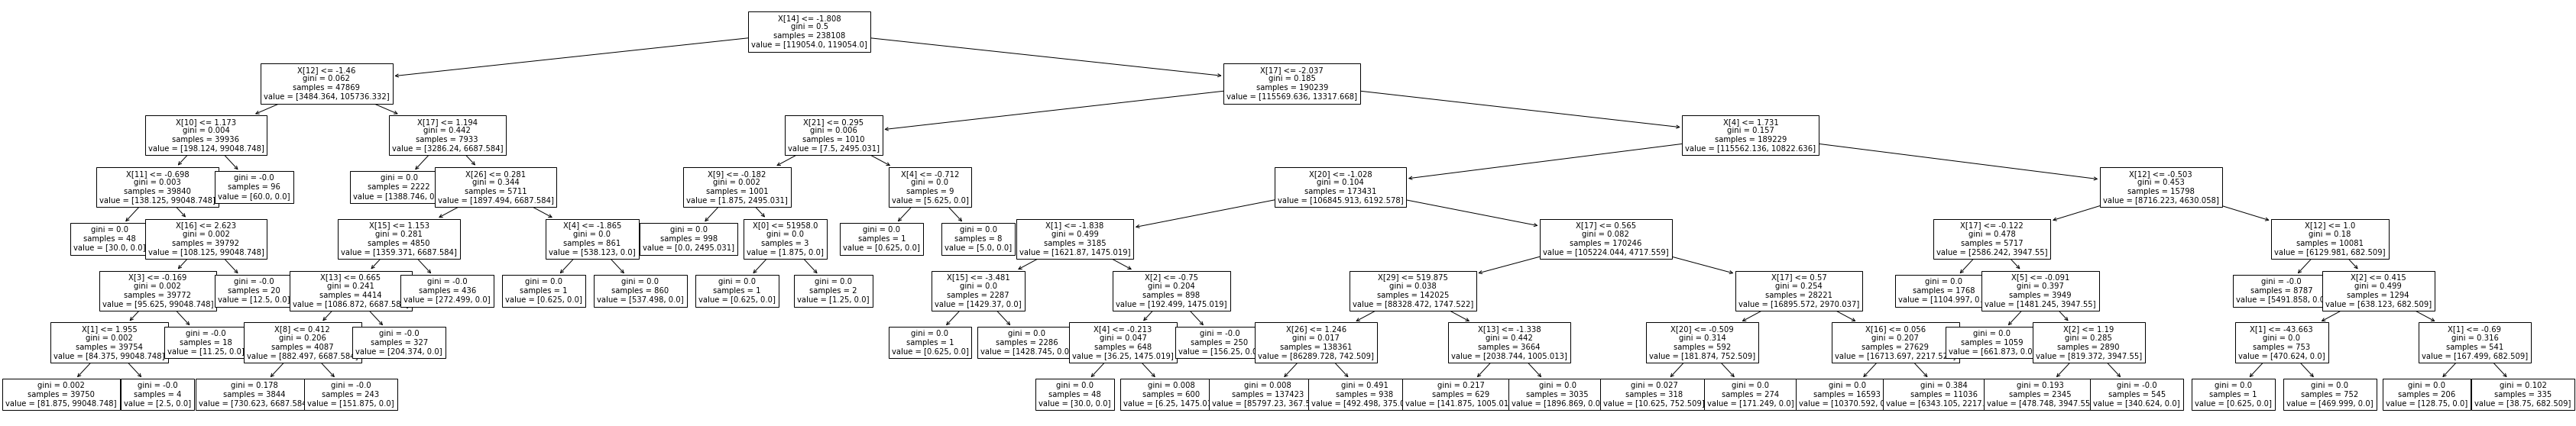

In [153]:
'''
Plot the upsample tree model
'''
plt.figure(figsize=(60,10))
tree.plot_tree(upsample_best_estimator, fontsize=10)
plt.show()

### *Step 6.4: Upsampled decision tree model metrics: accuracy, precision, recall, F1-Score* 

The upsampled tree model accuracy is :0.9880089799653143
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     93828
           1       0.10      0.81      0.19       159

    accuracy                           0.99     93987
   macro avg       0.55      0.90      0.59     93987
weighted avg       1.00      0.99      0.99     93987

The upsampled tree model confusion matrix: <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f889cdad518>


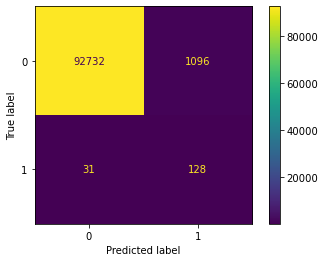

In [160]:
'''
Evaluate the upsampled tree model performance
'''
# Fit test data
y_pred = upsample_best_estimator.predict(X_test)


# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('The upsampled tree model accuracy is :{}'.format(accuracy))

# classification report (precision, recall, f1-score)
print(classification_report(y_test, y_pred))

# Confusion upsampled
print('The upsampled tree model confusion matrix: {}'.format(plot_confusion_matrix(upsample_best_estimator, X_test, y_test, values_format = 'd')))



### *Step 6.5: Calculate the average precision score and plot APPRC* 

The averge precision is: 0.49507423573172354


Text(0.5, 1.0, 'The upsampled tree model Precision-Recall curve: AP=0.50')

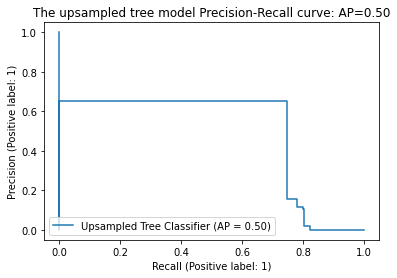

In [148]:
# precision, recall, _ = precision_recall_curve(y_test, y_pred)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

upsampled_tree_y_score = upsample_best_estimator.fit(upsampled_X_train, upsampled_y_train).predict_proba(X_test)

tree_ap_score = average_precision_score(y_test, upsampled_tree_y_score[:,1])
print('The averge precision is: {}'.format(tree_ap_score))
disp = plot_precision_recall_curve(upsample_best_estimator, X_test, y_test, name = 'Upsampled Tree Classifier')
disp.ax_.set_title('The upsampled tree model Precision-Recall curve: '
                   'AP={0:0.2f}'.format(tree_ap_score))

### *Step 6.6: Summarize the feature importance of the upsampled decision tree model* 

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.01255
Feature: 2, Score: 0.01040
Feature: 3, Score: 0.00020
Feature: 4, Score: 0.01873
Feature: 5, Score: 0.00712
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00216
Feature: 9, Score: 0.00003
Feature: 10, Score: 0.00107
Feature: 11, Score: 0.00053
Feature: 12, Score: 0.03759
Feature: 13, Score: 0.01258
Feature: 14, Score: 0.79007
Feature: 15, Score: 0.00348
Feature: 16, Score: 0.00585
Feature: 17, Score: 0.07052
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.01254
Feature: 21, Score: 0.00010
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00904
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00544


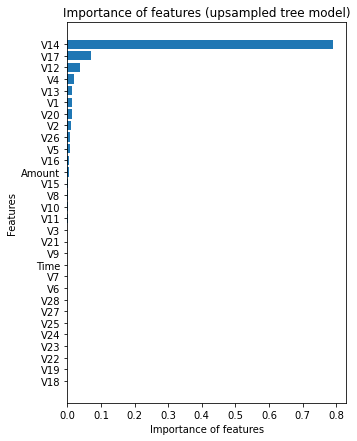

In [197]:
'''
Summarize the feature importance
'''
# get importance
imp = upsample_best_estimator.feature_importances_


# summarize feature importance
for i,v in enumerate(imp):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance    
names = X_train.columns
imp, names = zip(*sorted(zip(imp, names)))
plt.figure(figsize=(5,7))
plt.barh(range(len(names)),imp,align='center')
plt.yticks(range(len(names)), names)
plt.xlabel('Importance of features')
plt.ylabel('Features')
plt.title('Importance of features (upsampled tree model)')
plt.show()

## Step 7: Build a weighted decision tree (apply weight to the "bad" class as the fraud data is extremely imbalanced)

### *Step 7.1: Calculate the invert of the fraud ratio as the ceiling value of the weight list for the subsequent iteration*

In [105]:
fraud_percentage_summary

0.001727485630620034

In [ ]:
For example, the class distribution of the test dataset is a 1:100 ratio for the minority class to the majority class. The invert of this ratio could be used with 1 for the majority class and 100 for the minority class.

In [190]:
# 
# define model
invert_fraud_ratio = 1/fraud_percentage

weights = [{0:1.0, 1:100}, {0:1.0, 1:300}, {0:1.0, 1:400}, {0:1.0, 1:invert_fraud_ratio}]

### *Step 7.2: Grid search to identify the optimal weight, tree depth, and tree iteration criteria*

In [191]:
%%time
'''
Grid search to get the optimal parameters for the baseline tree model 
'''
# limit tree depth range to between 3 and 8
tree_depth_range = list(range(3,8))

# conduct 3-fold cross-validation 
cv_fold = 3

# apply a list of weight candidate
class_weight = weights

# fit the baseline tree model 
weighted_grid_search_tree = grid_search_best_tree(X_train, y_train, tree_depth_range, cv_fold, class_weight)

weighted_grid_search_tree.best_estimator_.get_params()

CPU times: user 6.41 s, sys: 241 ms, total: 6.65 s
Wall time: 4min 42s


{'ccp_alpha': 0.0,
 'class_weight': {0: 1.0, 1: 100},
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

### *Step 7.3: Apply the baseline tree model to the training data* 

In [192]:
'''
Build the weighted tree model 
'''
weighted_best_estimator = weighted_grid_search_tree.best_estimator_

# clf_baseline = DecisionTreeClassifier(best_estimator)
weighted_tree_model = weighted_best_estimator.fit(X_train, y_train)


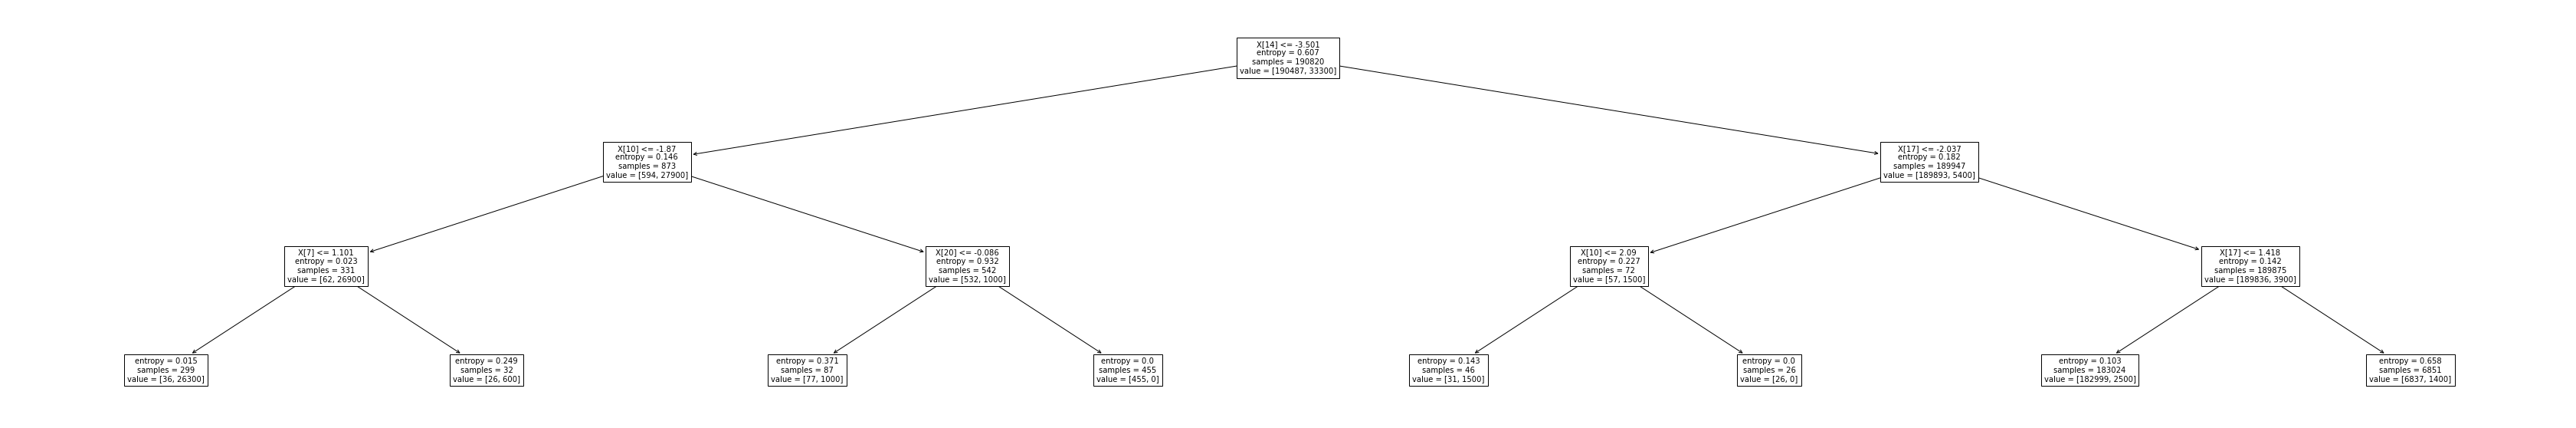

In [193]:
'''
Plot the weighted tree model
'''
plt.figure(figsize=(60,10))
tree.plot_tree(weighted_best_estimator, fontsize=10)
plt.show()

### *Step 7.4: The weighted decision tree model metrics: accuracy, precision, recall, F1-Score* 

The weighted tree model accuracy is :0.9985210720631577
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93828
           1       0.54      0.78      0.64       159

    accuracy                           1.00     93987
   macro avg       0.77      0.89      0.82     93987
weighted avg       1.00      1.00      1.00     93987

The weighted tree model confusion matrix: <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7f88981b0f60>


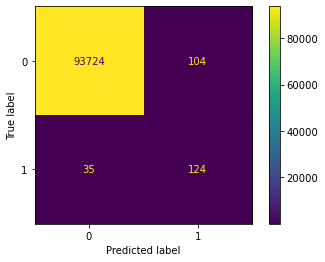

In [194]:
'''
Evaluate the weighted tree model performance
'''
# Fit test data
y_pred = weighted_best_estimator.predict(X_test)


# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print('The weighted tree model accuracy is :{}'.format(accuracy))

# classification report (precision, recall, f1-score)
print(classification_report(y_test, y_pred))

# Confusion upsampled
print('The weighted tree model confusion matrix: {}'.format(plot_confusion_matrix(weighted_best_estimator, X_test, y_test, values_format = 'd')))



### *Step 7.5: Calculate the average precision score and plot APPRC* 

The averge precision is: 0.6391459064157986


Text(0.5, 1.0, 'The weighted tree model Precision-Recall curve: AP=0.64')

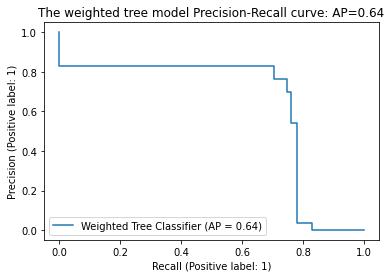

In [195]:
# precision, recall, _ = precision_recall_curve(y_test, y_pred)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

weighted_tree_y_score = weighted_best_estimator.fit(X_train, y_train).predict_proba(X_test)

tree_ap_score = average_precision_score(y_test, weighted_tree_y_score[:,1])
print('The averge precision is: {}'.format(tree_ap_score))
disp = plot_precision_recall_curve(weighted_best_estimator, X_test, y_test, name = 'Weighted Tree Classifier')
disp.ax_.set_title('The weighted tree model Precision-Recall curve: '
                   'AP={0:0.2f}'.format(tree_ap_score))

### *Step 7.6: Summarize the feature importance of the weighted decision tree model* 

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00075
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.02034
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.87195
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.09764
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00933
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000


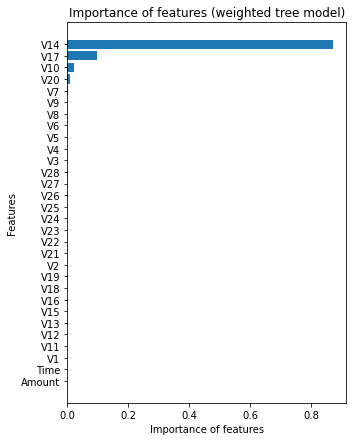

In [199]:
'''
Summarize the feature importance
'''
# get importance
imp = weighted_best_estimator.feature_importances_


# summarize feature importance
for i,v in enumerate(imp):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance    
names = X_train.columns
imp, names = zip(*sorted(zip(imp, names)))
plt.figure(figsize=(5,7))
plt.barh(range(len(names)),imp,align='center')
plt.yticks(range(len(names)), names)
plt.xlabel('Importance of features')
plt.ylabel('Features')
plt.title('Importance of features (weighted tree model)')
plt.show()